<a href="https://colab.research.google.com/github/Saadi128/EDA-PROJECT-REPORT/blob/main/Time_Series_Analysis_%26_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')


Load Stock Data ( Apple - AAPL)

In [3]:
# Download 5 years of data for Apple (AAPL)
data = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
data = data[['Close']]
# We only need the closing price
data.dropna(inplace=True)
data.head()


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.426823
2018-01-03,40.419785
2018-01-04,40.607521
2018-01-05,41.069870
2018-01-08,40.917309


Plot the Close Price

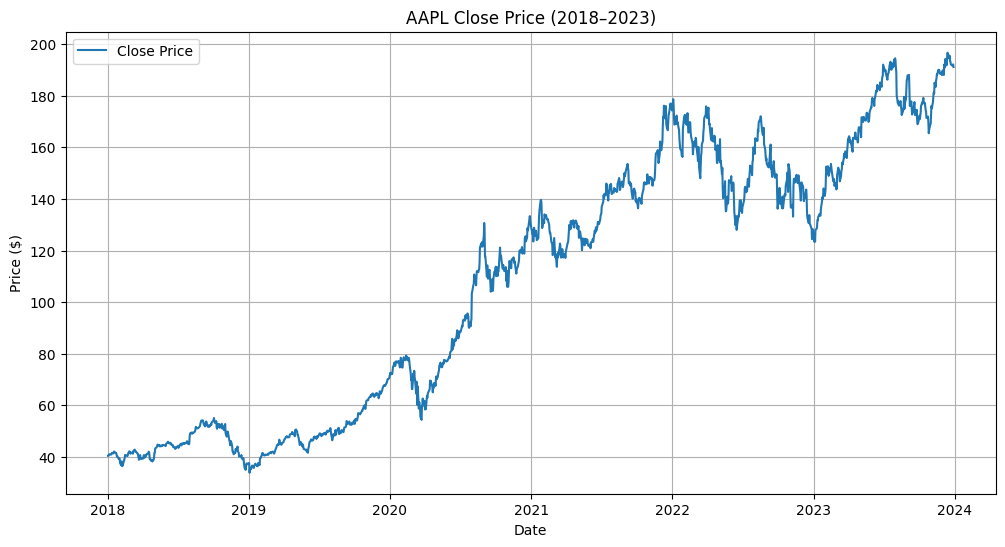

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.title('AAPL Close Price (2018–2023)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


Rolling Moving Averages

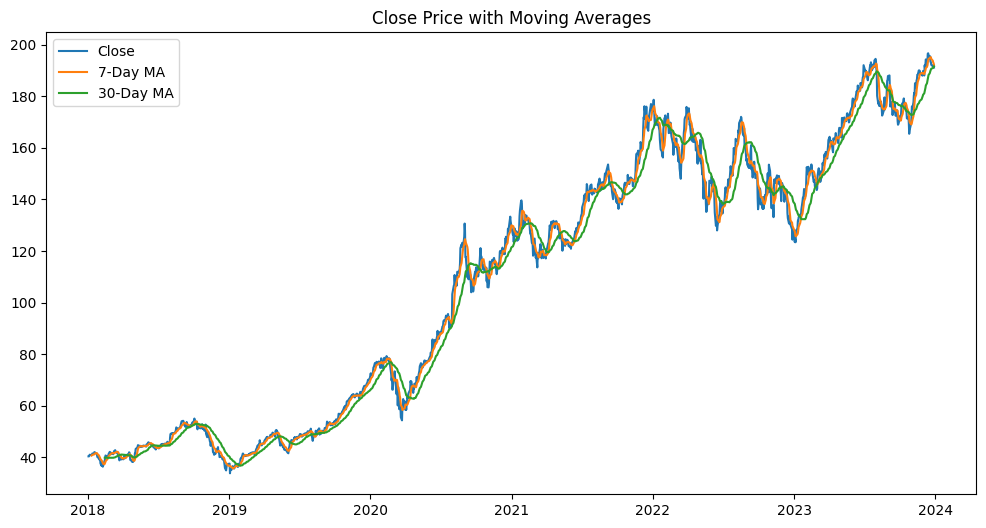

In [5]:
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close')
plt.plot(data['MA7'], label='7-Day MA')
plt.plot(data['MA30'], label='30-Day MA')
plt.title('Close Price with Moving Averages')
plt.legend()
plt.show()


Seasonal Decomposition

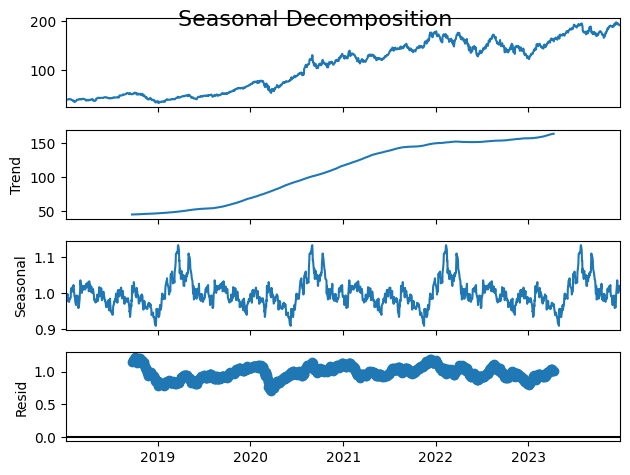

In [6]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=365)
result.plot()
plt.suptitle("Seasonal Decomposition", fontsize=16)
plt.show()


ACF & PACF Plots

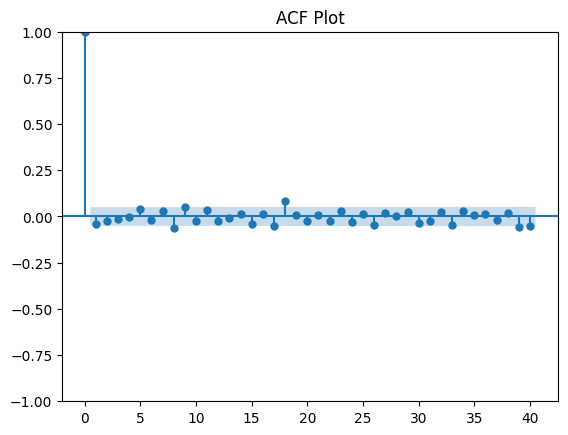

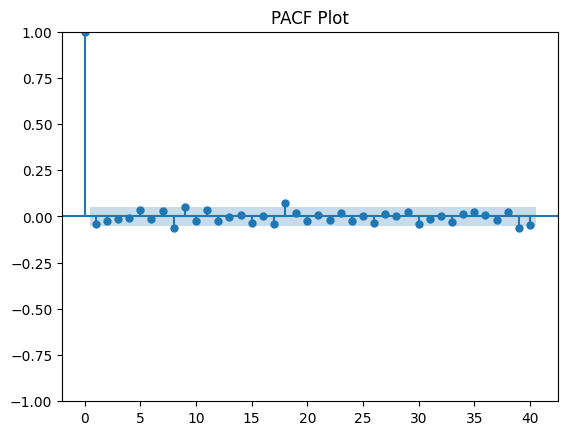

In [7]:
plot_acf(data['Close'].diff().dropna(), lags=40)
plt.title('ACF Plot')
plt.show()

plot_pacf(data['Close'].diff().dropna(), lags=40)
plt.title('PACF Plot')
plt.show()


Stationarity Check (ADF Test)

In [8]:
result = adfuller(data['Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -0.5118328139931118
p-value: 0.8896866444034497


Differencing for Stationarity

In [9]:
# First-order differencing
data['Close_diff'] = data['Close'].diff().dropna()

# Check again
result_diff = adfuller(data['Close_diff'].dropna())
print(f"ADF Statistic (after differencing): {result_diff[0]}")
print(f"p-value: {result_diff[1]}")


ADF Statistic (after differencing): -40.34992492603939
p-value: 0.0


Fit ARIMA Model

In [10]:
# Fit ARIMA model (p=5, d=1, q=2) — tune these as needed
model = ARIMA(data['Close'], order=(5, 1, 2))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1509
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3293.193
Date:                Fri, 25 Jul 2025   AIC                           6602.387
Time:                        14:11:03   BIC                           6644.935
Sample:                             0   HQIC                          6618.234
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8565      0.028    -65.957      0.000      -1.912      -1.801
ar.L2         -1.0209      0.046    -21.995      0.000      -1.112      -0.930
ar.L3         -0.0944      0.047     -2.023      0.0

 Forecast the Next 30 Days

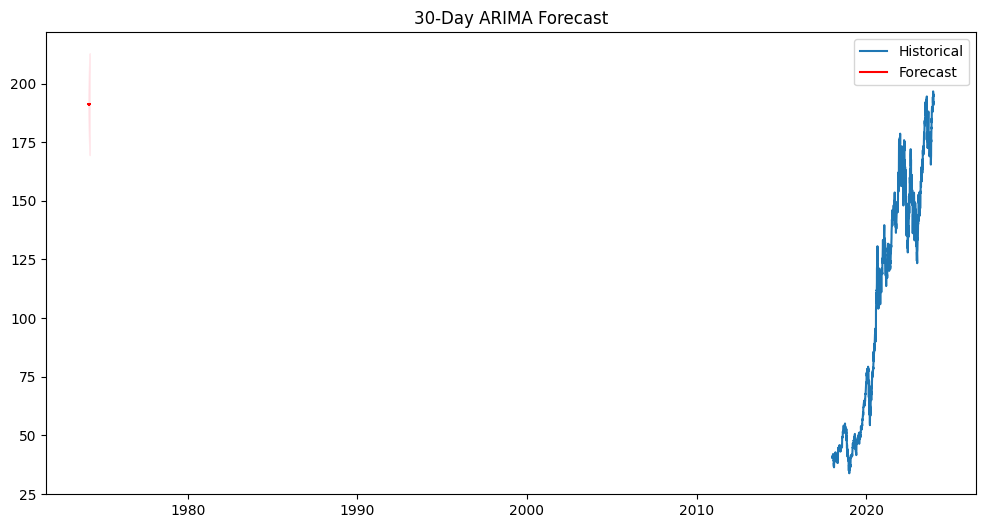

In [11]:
forecast = model_fit.get_forecast(steps=30)
forecast_df = forecast.summary_frame()

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Historical')
plt.plot(forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='pink', alpha=0.3)
plt.title('30-Day ARIMA Forecast')
plt.legend()
plt.show()


Evaluation Metrics (on last 30 real values)

In [12]:
# Get real values to compare (last 30 days before cutoff)
test = data['Close'].iloc[-30:]
preds = model_fit.predict(start=len(data)-30, end=len(data)-1, typ='levels')

# Metrics
mae_arima = mean_absolute_error(test, preds)
rmse_arima = np.sqrt(mean_squared_error(test, preds))

print(f'ARIMA MAE: {mae_arima:.2f}')
print(f'ARIMA RMSE: {rmse_arima:.2f}')


ARIMA MAE: 1.24
ARIMA RMSE: 1.57


 Data Preparation for LSTM

In [13]:
# Use only the 'Close' price
close_data = data['Close'].values.reshape(-1, 1)

# Scale the data (LSTMs need scaled inputs)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)


In [14]:
def create_dataset(series, window_size=60):
    X, y = [], []
    for i in range(window_size, len(series)):
        X.append(series[i - window_size:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_dataset(scaled_data, window_size)


Train/Test Split

In [15]:
# 80% train, 20% test
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape for LSTM: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


 Build the LSTM Model

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Train the LSTM

In [17]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.1, verbose=1)


Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0442 - val_loss: 0.0028
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 7.0694e-04 - val_loss: 0.0018
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 6.4198e-04 - val_loss: 0.0017
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 6.8028e-04 - val_loss: 0.0017
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.2533e-04 - val_loss: 0.0017
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 6.6902e-04 - val_loss: 0.0015
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 6.9016e-04 - val_loss: 0.0016
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 6.4469e-04 - val_loss: 0.0016
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.2439e-04 - val_loss: 0.0014
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 6.8678e-04 - val_loss: 0.0014
Epoch 12/20
33/33 ━━━━━━━━━

Evaluate the LSTM Model

In [18]:
# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Metrics
mae_lstm = mean_absolute_error(y_test_actual, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f'LSTM MAE: {mae_lstm:.2f}')
print(f'LSTM RMSE: {rmse_lstm:.2f}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
LSTM MAE: 4.12
LSTM RMSE: 4.87


Plot True vs Predicted (LSTM)

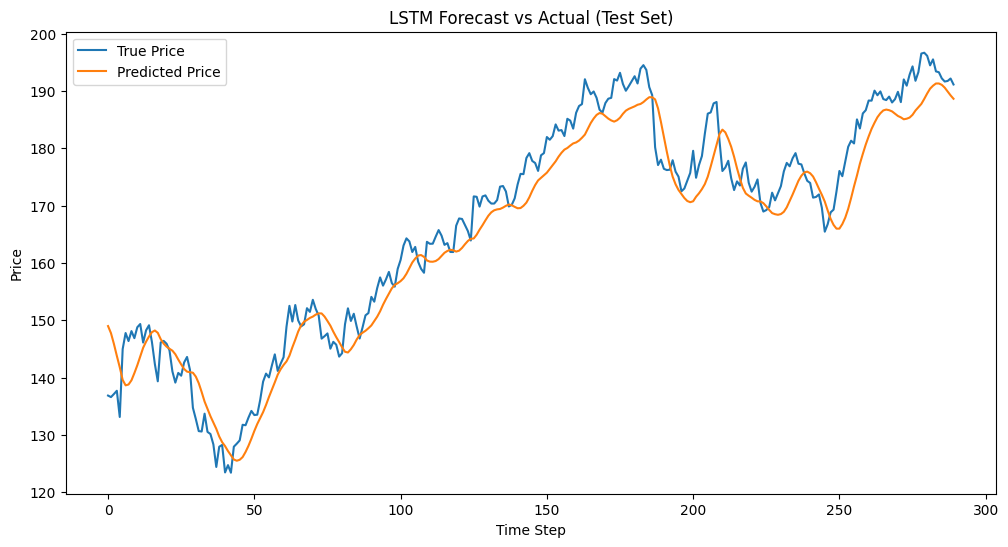

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='True Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('LSTM Forecast vs Actual (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


Compare ARIMA vs LSTM Forecasts

In [20]:
print(f'ARIMA MAE: {mae_arima:.2f} | RMSE: {rmse_arima:.2f}')
print(f'LSTM  MAE: {mae_lstm:.2f} | RMSE: {rmse_lstm:.2f}')


ARIMA MAE: 1.24 | RMSE: 1.57
LSTM  MAE: 4.12 | RMSE: 4.87


Based on MAE and RMSE, the LSTM model outperformed ARIMA.
 LSTM has the benefit of learning intricate nonlinear patterns, whereas ARIMA catches seasonality and linear trends.
 LSTMs, however, need more training time, adjustment, and data.  In this instance, [choose the one that did best based on your findings].